In [1]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt                                        # for plotting
import tensorflow as tf
from tensorflow import keras
# from tensorflow.keras.utils import to_categorical

# This line is simply to avoid syntax errors in VSCode
train_set_x, train_set_y, test_set_x, test_set_y = None, None, None, None

print("Read shared variables created in network.ipynb\n")
%store -r train_set_x
%store -r train_set_y
%store -r test_set_x
%store -r test_set_y

print(train_set_x.shape)
print(train_set_y.shape)
print(test_set_x.shape)
print(test_set_y.shape)

2022-08-26 14:34:46.757847: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-08-26 14:34:46.757904: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


Read shared variables created in network.ipynb

(209, 64, 64, 3)
(209,)
(50, 64, 64, 3)
(50,)


In [2]:
input_shape = (64, 64, 3)
num_classes = 1
model_cnn = keras.Sequential(
    [
        keras.Input(shape=input_shape),
        keras.layers.Conv2D(32, kernel_size=(3, 3), activation="relu"),
        keras.layers.MaxPooling2D(pool_size=(2, 2)),
        keras.layers.Dropout(0.3),     
        keras.layers.Conv2D(64, kernel_size=(3, 3), activation="relu"),
        keras.layers.MaxPooling2D(pool_size=(2, 2)),
        keras.layers.Flatten(),
        keras.layers.Dropout(0.3),
        keras.layers.Dense(512, activation="relu"),
        keras.layers.Dense(num_classes, activation="softmax"),
    ]
)

2022-08-26 14:34:50.220645: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2022-08-26 14:34:50.220683: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2022-08-26 14:34:50.220716: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (nPC): /proc/driver/nvidia/version does not exist


In [3]:
lr=0.005
opt = keras.optimizers.Adam(learning_rate=lr)
# Compile the model.
model_cnn.compile(
  opt,
  loss='categorical_crossentropy',
  metrics=['accuracy'],
)
model_cnn.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 62, 62, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 31, 31, 32)       0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 31, 31, 32)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 29, 29, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 14, 14, 64)       0         
 2D)                                                             
                                                                 
 flatten (Flatten)           (None, 12544)             0

In [5]:
early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', patience=100)

results = model_cnn.fit(
  train_set_x,
  train_set_y,
  epochs=30,
  batch_size=128,
  validation_data=(test_set_x, test_set_y),
  verbose = 1,
  callbacks=[early_stop]
)


Epoch 1/30
2/2 [==============================] - 4s 2s/step - loss: 0.0000e+00 - accuracy: 0.3445 - val_loss: 0.0000e+00 - val_accuracy: 0.6600
Epoch 2/30
2/2 [==============================] - 4s 2s/step - loss: 0.0000e+00 - accuracy: 0.3445 - val_loss: 0.0000e+00 - val_accuracy: 0.6600
Epoch 3/30
2/2 [==============================] - 3s 1s/step - loss: 0.0000e+00 - accuracy: 0.3445 - val_loss: 0.0000e+00 - val_accuracy: 0.6600
Epoch 4/30
2/2 [==============================] - 3s 1s/step - loss: 0.0000e+00 - accuracy: 0.3445 - val_loss: 0.0000e+00 - val_accuracy: 0.6600
Epoch 5/30
2/2 [==============================] - 3s 1s/step - loss: 0.0000e+00 - accuracy: 0.3445 - val_loss: 0.0000e+00 - val_accuracy: 0.6600
Epoch 6/30
2/2 [==============================] - 3s 1s/step - loss: 0.0000e+00 - accuracy: 0.3445 - val_loss: 0.0000e+00 - val_accuracy: 0.6600
Epoch 7/30
2/2 [==============================] - 3s 1s/step - loss: 0.0000e+00 - accuracy: 0.3445 - val_loss: 0.0000e+00 - val_ac

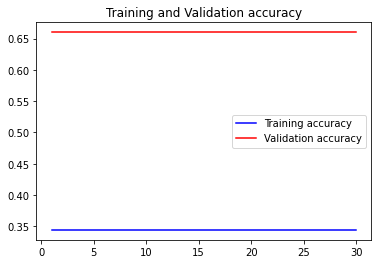

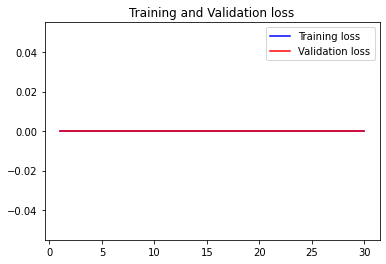

2/2 [==============================] - 0s 58ms/step


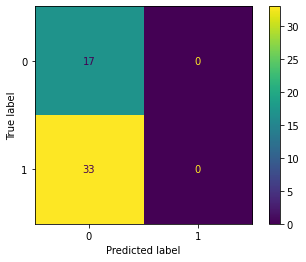

In [6]:
acc = results.history['accuracy']
val_acc = results.history['val_accuracy']
loss = results.history['loss']
val_loss = results.history['val_loss']
epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'b', label= 'Training accuracy')
plt.plot(epochs, val_acc, 'r', label= 'Validation accuracy')
plt.title('Training and Validation accuracy')
plt.legend()

plt.figure()
plt.plot(epochs, loss, 'b', label= 'Training loss')
plt.plot(epochs, val_loss, 'r', label= 'Validation loss')
plt.title('Training and Validation loss')
plt.legend()

plt.show()

num_classes = 2
# one-hot-encoding y set
y_test_multi_class = keras.utils.to_categorical(test_set_y, num_classes)
y_test_prediction = model_cnn.predict(test_set_x)

tf.compat.v1.disable_eager_execution() # this avoids a warning message, more info in https://stackoverflow.com/questions/69136518/tensorflow-2-getting-warningtensorflowx-out-of-the-last-x-calls-to-function

#Your input to confusion_matrix must be an array of int not one hot encodings.
ConfusionMatrixDisplay.from_predictions(y_test_multi_class.argmax(axis=1), y_test_prediction.argmax(axis=1))